In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import astra
astra.set_gpu_index((0, 1, 2, 3))

from AdversarialRegularizer_FoV import AdversarialSplitting
from networks_FoV import ResNetL2, ResNetL2_local
from ellipsgen.generate_data_function import get_batch
import numpy as np
import ellipsgen.CCB_class as CT
import ellipsgen.phantom_class as ph
import matplotlib.pyplot as plt

LOOPS = 2
STEPS = 100

In [2]:
# Parameter choices. Heuristic in the BWGAN paper: Choose GAMMA as average dual norm of clean image
# LMB should be bigger than product of norm times dual norm.

# For s=0.0, this implies GAMMA =1.0
# For s=1.0, have GAMMA = 10.0 as realisitc value

saves_path = '/export/scratch1/home/voxels-gpu0/codesprint_learned_prior/AdvRegSaves/FoV_experiments'
regularizer = AdversarialSplitting(saves_path, NETWORK=ResNetL2_local, BATCH_SIZE=4)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv3d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.average_pooling3d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
No save found


In [3]:
def load_pair(i):
    prefix = '../noisy_' + str(IMG_SIZE) + '/'
    fdk = np.load(prefix + 'FDK/dataset' + str(i) + '.npy')
    gt = np.load(prefix + 'GT/dataset' + str(i) + '.npy')
    
    return fdk, gt

IMG_SIZE = 128
def generate_pairs(amount=1):
    num_angles = 360
    noise = ['Poisson', 2 ** 14] # Do not go below 2 ** 8, lower number in the 2nd argument means more noise
    num_vox = IMG_SIZE
    
    voxels = [num_vox, num_vox, num_vox]
    src_rad = 10
    det_rad = 0

    fdks = np.empty((amount, *voxels))
    gts = np.empty_like(fdks)

    for i in range(amount):
        data_obj = ph.phantom(voxels, '22 Ellipses', num_angles, noise, src_rad, det_rad)
        gts[i, ...] =  data_obj.f

        case = CT.CCB_CT(data_obj)
        fdks[i, ...] = case.do_FDK()
        
        if i == 0:
            plt.figure()
            plt.imshow(gts[i, int(IMG_SIZE/2), ...])
            plt.show()
            
            plt.figure()
            plt.imshow(fdks[i, int(IMG_SIZE/2), ...])
            plt.show()
            
    
    return (gts[0,...], fdks[0,...])

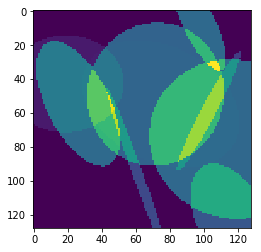

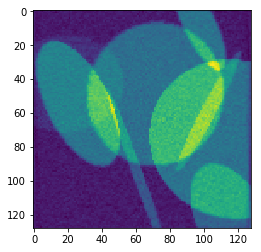

In [4]:
gt, fbp = generate_pairs()

In [ ]:
regularizer.train(gt, fbp, learning_rate=1e-4)

(162, 162, 162)
(162, 162, 162)
Training on batch of size (4, 98, 98, 98)
Training on batch of size (4, 98, 98, 98)


In [ ]:
def evaluate(gt, adv):
    # gt, adv = get_batch(eval_data=True, noise_levels=['01', '016'], methods=['EM', 'SGD'])
    regularizer.test(groundTruth=gt, adversarial=adv)

    
def train(steps):
    for k in range(steps):        
        if k%50 == 0:
            gt, adv = generate_pairs(amount=1) # batch, x, y, z, channel
            evaluate(gt, adv)
        else:
            gts, advs = generate_pairs(amount=BATCH_SIZE) # batch, x, y, z, channel
            regularizer.train(groundTruth=gts, adversarial=advs, learning_rate=LEARNING_RATE)
            
    regularizer.save()

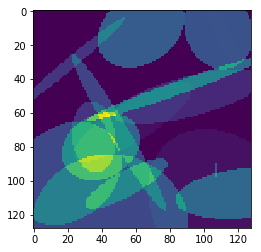

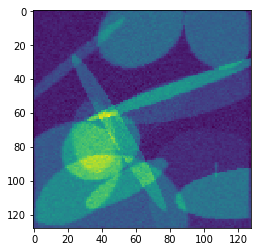

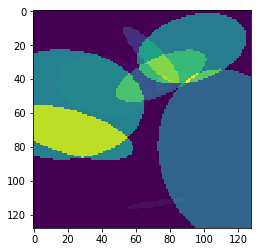

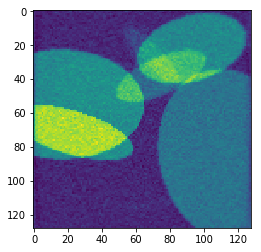

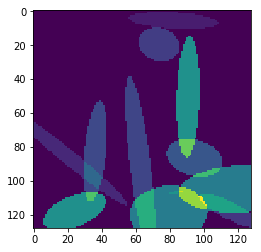

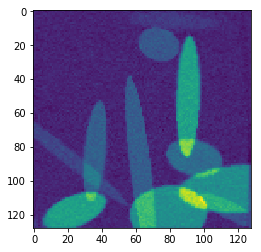

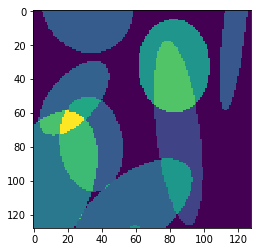

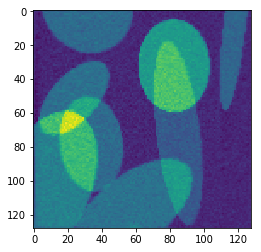

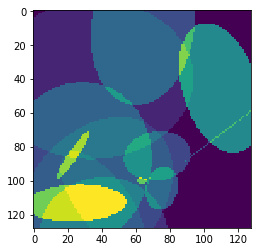

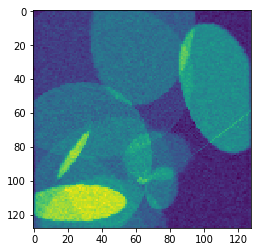

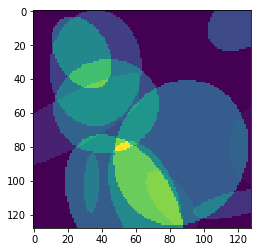

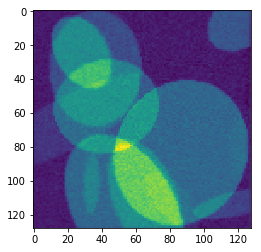

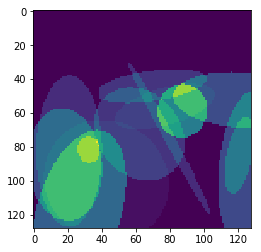

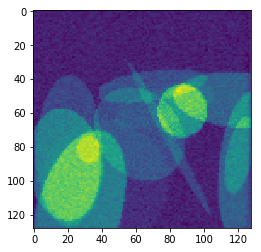

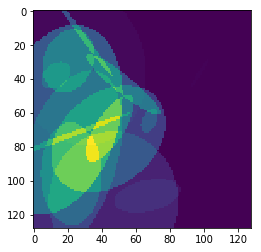

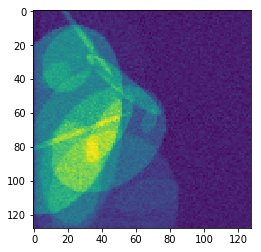

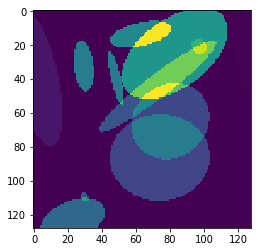

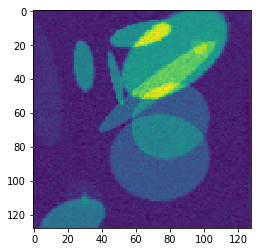

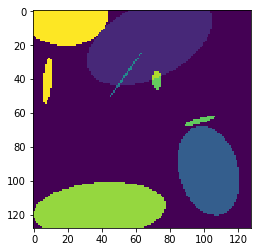

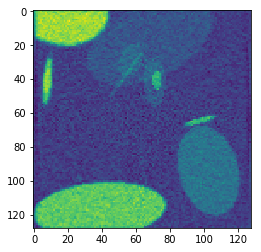

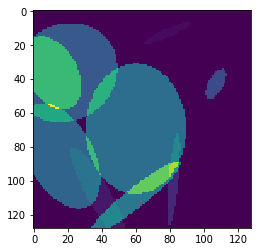

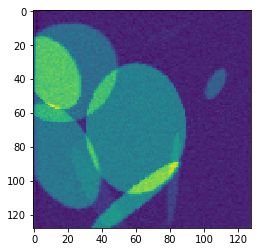

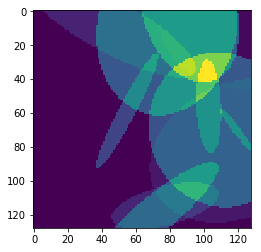

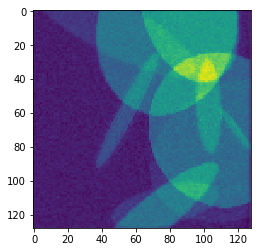

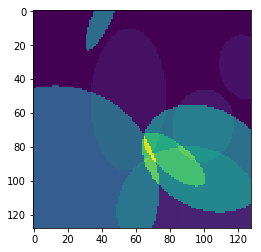

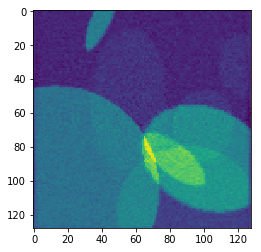

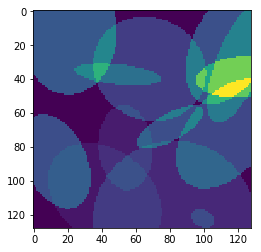

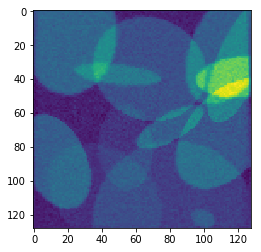

In [ ]:
LEARNING_RATE = 0.00005
for k in range(LOOPS):
    train(STEPS)

LEARNING_RATE = 0.00002
for k in range(LOOPS):
    train(STEPS)